# Mutual information between Reads and MAGs

This notebook measures the overlap between the reads and the MAGs.

We want to know which MAGs (genomes) are most strongly associated with the latent biological gradients (COPFs) that emerged from the autoencoder trained on taxonomy + function data.

We use mutual information because:
 - it captures any relationship (linear or non-linear),
 - it’s robust to scale and zero-inflation,
 - and it tells you how much knowing one variable reduces uncertainty about the other.

We start by recreating the latent dimensions from our autoencoder, and then correlate the MAG abundance with those dimensions.

In [1]:
import os
import sys
import torch

import tensorflow as tf
from tensorflow.keras import layers, models

if not torch.cuda.is_available():
    print("FATAL: Please run this notebook in an environment with CUDA available", file=sys.stderr)
else:
    print("Lets go GPU", file=sys.stderr)
    
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

2025-10-31 12:23:05.788156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Lets go GPU


In [2]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

training_data, validate_data = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {training_data.shape}")
print(f"Test: {validate_data.shape}")

Train: (101, 1512)
Test: (26, 1512)


Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


## Read the autoencoder model and recreate the latent dimensions

This uses the test and training data from above

In [3]:
outdir = 'cluster_gbrfs'
if not os.path.exists(outdir):
    raise Exception(f"FATAL: Path does not exist: {outdir}")
print(f"Loading the autoencoder from disk.", file=sys.stderr)
autoencoder = models.load_model(os.path.join(outdir, "autoencoder_model"), compile=False)
autoencoder.compile(optimizer='adam', loss='mse')
encoder = models.load_model(os.path.join(outdir, "encoder_model"), compile=False)
decoder = models.load_model(os.path.join(outdir, "decoder_model"), compile=False)
encoder.compile()
decoder.compile()
train_latent = encoder.predict(training_data)
val_latent = encoder.predict(validate_data)
latent_dimensions = encoder.predict(df)

Loading the autoencoder from disk.
2025-10-31 12:23:11.754865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1167 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:41:00.0, compute capability: 7.0


4/4 [==============================] - 0s 2ms/step


## Recreate the correlation matrix.

We need this to look at the correlations between MAGs and latent dimensions.

In [4]:
num_features = df.shape[1]  # 1512
num_latent_dims = latent_dimensions.shape[1]       # 50 - the number of output layers

corr_matrix = pd.DataFrame(index=df.columns, columns=[f"LD_{i}" for i in range(num_latent_dims)])

for i in range(num_features):
    for j in range(num_latent_dims):
        try:
            corr = np.corrcoef(df.iloc[:, i], latent_dimensions[:, j])[0, 1]
            corr_matrix.iloc[i, j] = corr
        except:
            print(f"Error predicting {i} and {j}", file=sys.stderr)
            break

corr_matrix = corr_matrix.astype(float)

# Calculate linkage on the rows (i.e., the features)
Z = linkage(corr_matrix, method='ward', metric='euclidean')

k = 150  # more clusters, smaller groups!
clusters = fcluster(Z, k, criterion='maxclust')  # Each feature gets a cluster ID [1..k]

# create a df with the cluster assignments
cluster_assignments = pd.DataFrame({
    "Feature": corr_matrix.index,  # the feature names
    "COPF": clusters
})
cluster_assignments.sort_values("COPF", inplace=True)
grouped = cluster_assignments.groupby("COPF")
by_cluster = {str(cluster_id): group["Feature"].tolist() for cluster_id, group in grouped}

# we print out the interesting clusters to make sure it is the same cluster numbers we've been using previously
# cluster 31 should be our Pseudomonas friend.
interesting_cluster = None
interesting_cluster_count = 0
grouped = cluster_assignments.groupby("COPF")
for cluster_id, group in grouped:
    if group['Feature'].str.contains('Pseudomonas').any():
        if group['Feature'].str.contains('Pseudomonas').sum() > interesting_cluster_count:
            interesting_cluster_count = group['Feature'].str.contains('Pseudomonas').sum()
            interesting_cluster = cluster_id
        print(f"--- COPF {cluster_id} : Length {group['Feature'].shape[0]} ---")
        print(group["Feature"].tolist())
        print()
print(f"Interesting cluster is {interesting_cluster}", file=sys.stderr)

--- COPF 31 : Length 40 ---
['Sulfur transfer pathway CsdAEL', 'Sulfate assimilation related cluster', 'Stress proteins YciF, YciE', 'Two partner secretion pathway (TPS)', 'Type 4 conjugative transfer system, IncI1 type', 'Type III secretion systems', 'Siderophore Pyoverdine', 'Trans-envelope signaling system VreARI in Pseudomonas', 'L-2-amino-4-methoxy-trans-3-butenoic acid synthesis', 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas', 'Extracellular matrix proteins (PSL) involved in mannose-rich biofilm formation in Pseudomonas', 'IbrA and IbrB: co-activators of prophage gene expression', 'Rhamnolipids in Pseudomonas', 'Respiratory Systems - Shewanella (updated)', 'Phenazine biosynthesis', 'Periplasmic nitrate reductase EC 1.7.99.4', 'Outer membrane porins in Pseudomonas and Acinetobacter', 'Mycobacterial gene cluster associated with resistance against FAS-II antibiotics', 'Mycobacterial FadE proteins Acyl-CoA dehydrogenase', 'Mycobacteri

Interesting cluster is 31


## Read the MAG data

In [5]:
mag_metadata = cf_analysis_lib.read_mag_metadata()
# which MAG looks like Pseudomonas ... is it odd that we only have one?
mag_metadata[(mag_metadata['BV-BRC Mash'].astype(str).str.contains('Pseudomo', case=False)) | (mag_metadata['CheckM'].astype(str).str.contains('Pseudomo', case=False))]

,MAG,CheckM,UID,# genomes,# markers,# marker sets,0,1,2,3,4,5+,Completeness,Contamination,Strain heterogeneity,BV-BRC Mash,contigs,total size,BV-BRC Protein,GTDB
Bin Id,,,,,,,,,,,,,,,,,,,,
12,mag_12,o__Pseudomonadales,(UID4488),185,813,308,4,800,8,1,0,0,99.27,1.6,72.73,Pseudomonas,406,6428243,Pseudomonas,Pseudomonas


In [6]:
list(mag_metadata.columns)

['MAG',
 'CheckM',
 'UID',
 '# genomes',
 '# markers',
 '# marker sets',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5+',
 'Completeness',
 'Contamination',
 'Strain heterogeneity',
 'BV-BRC Mash',
 'contigs',
 'total size',
 'BV-BRC Protein',
 'GTDB']

In [7]:
mag_coverage = cf_analysis_lib.read_mag_coverage()
# For Mag Coverage (M): log-transform MAG abundances to stabilise variance.
M_log = np.log10(mag_coverage + 1e-6)
print(f"MAG coverage has shape {M_log.shape}")
# For latent_dimensions (Z): scale each latent dimension to zero mean and unit variance
Z_scaled = StandardScaler().fit_transform(latent_dimensions)
print(f"Latent dimensions has shape {Z_scaled.shape}")

MAG coverage has shape (127, 3215)
Latent dimensions has shape (127, 50)


# Calculate a mutual information matrix

mi_matrix[j, k] = how much information MAG j shares with latent dimension k.

In [8]:
mi_matrix = np.zeros((M_log.shape[1], Z_scaled.shape[1]))

for k in range(Z_scaled.shape[1]):
    mi_matrix[:, k] = mutual_info_regression(M_log, Z_scaled[:, k], random_state=42)


We convert this to a dataframe and normalise it so that for every LD, the strongest MAG association = 1 and all others fall between 0 and 1.

In [9]:
mi_df = pd.DataFrame(mi_matrix, index=mag_coverage.columns, columns=[f"LD_{i+1}" for i in range(mi_matrix.shape[1])])
mi_norm_df = mi_df.div(mi_df.max(axis=0), axis=1)
mi_norm_df

,LD_1,LD_2,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,LD_9,LD_10,...,LD_41,LD_42,LD_43,LD_44,LD_45,LD_46,LD_47,LD_48,LD_49,LD_50
mag_1,0.000000,0.043525,0.163845,0.021582,0.008014,0.000000,0.000000,0.071087,0.000000,0.033050,...,0.000000,0.001004,0.027313,0.028001,0.000000,0.000000,0.004171,0.000000,0.132638,0.025526
mag_2,0.000000,0.197205,0.100857,0.165387,0.328049,0.451996,0.575145,0.000000,0.062050,0.110022,...,0.303607,0.422958,0.206689,0.088218,0.183117,0.168489,0.331437,0.347517,0.210445,0.050843
mag_3,0.125659,0.510200,0.219636,0.781081,0.655893,0.391286,0.495010,0.763858,0.468897,0.188548,...,0.196767,0.745224,0.790150,0.373337,0.969552,0.358896,0.686636,0.808016,0.611863,0.133519
mag_4,0.346193,0.345025,0.387420,0.180530,0.000000,0.310526,0.202004,0.189828,0.059350,0.127647,...,0.186094,0.034354,0.096002,0.076004,0.132424,0.123321,0.279470,0.701727,0.000000,0.000000
mag_5,0.000000,0.180387,0.106984,0.052028,0.095197,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.107321,0.043412,0.000000,0.034015,0.021601,0.010293,0.032373,0.182598,0.038257,0.006700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mag_70473,0.203357,0.150323,0.132798,0.239435,0.694277,0.309491,0.087648,0.288736,0.050845,0.298644,...,0.245954,0.011471,0.412290,0.209532,0.237853,0.308146,0.098880,0.147671,0.462295,0.096354
mag_72938,0.339618,0.302716,0.008096,0.215882,0.320233,0.106333,0.173218,0.195521,0.000000,0.095000,...,0.289551,0.102610,0.127040,0.036652,0.070634,0.260256,0.020499,0.000000,0.430166,0.037066
mag_75531,0.000000,0.101510,0.134922,0.160188,0.113746,0.036249,0.089972,0.004197,0.063191,0.144364,...,0.148241,0.023110,0.076046,0.071108,0.053130,0.075113,0.000000,0.129217,0.177243,0.000000
mag_77836,0.016307,0.259146,0.172924,0.198354,0.193012,0.125021,0.186042,0.298446,0.000000,0.127974,...,0.399966,0.637075,0.279026,0.000000,0.233718,0.191522,0.356873,0.327628,0.193610,0.000000


## Identify the most informative MAGs for each latent dimension

We keep every MAG whose MI ≥ 95th percentile for that latent dimension

In [10]:
top95 = {}
for k, col in enumerate(mi_norm_df.columns):
    cutoff = mi_norm_df[col].quantile(0.95)
    top95[col] = mi_norm_df.index[mi_norm_df[col] >= cutoff].tolist()


In [11]:
records = []
for ld in mi_norm_df.columns:
    for mag in mi_norm_df.index:
        records.append({
            "MAG": mag,
            "LatentDim": ld,
            "MI_norm": mi_norm_df.loc[mag, ld]
        })

mi_long = pd.DataFrame.from_records(records)
mi_long[mi_long["MI_norm"] > 0.95]

,MAG,LatentDim,MI_norm
882,mag_38045,LD_1,1.000000
2359,mag_41634,LD_1,0.952192
2874,mag_44342,LD_1,0.983638
6019,mag_43887,LD_2,0.964245
6082,mag_44298,LD_2,1.000000
...,...,...,...
155814,mag_39109,LD_49,1.000000
156118,mag_39879,LD_49,0.971426
156664,mag_41591,LD_49,0.989796
157497,mag_55618,LD_49,0.967882


## Compare the relationship between individual MAGs and latent dimensions

Which latent dimensions most closely match our _Pseudomonas_ MAG

In [12]:
mi_long[mi_long["MAG"]=='mag_12'][['LatentDim', 'MI_norm']].sort_values(by='MI_norm', ascending=False).head(10)

,LatentDim,MI_norm
41806,LD_14,0.658889
77171,LD_25,0.619161
131826,LD_42,0.521523
135041,LD_43,0.471671
109321,LD_35,0.444630
38591,LD_13,0.408834
11,LD_1,0.398145
64311,LD_21,0.381928
99676,LD_32,0.367137
51451,LD_17,0.357254


Identify top latent dimensions for each MAG

Each MAG will have high MI with a small subset of latent dimensions. 

This tells us for each MAG, which latent dimensions it’s most strongly associated with.

In [13]:
top_ld_per_mag = {}
threshold = 0.95  # or any quantile cutoff you chose earlier

for mag, row in mi_norm_df.iterrows():
    top_ld = row[row >= threshold].index.tolist()
    top_ld_per_mag[mag] = top_ld
top_ld_per_mag['mag_12']

[]

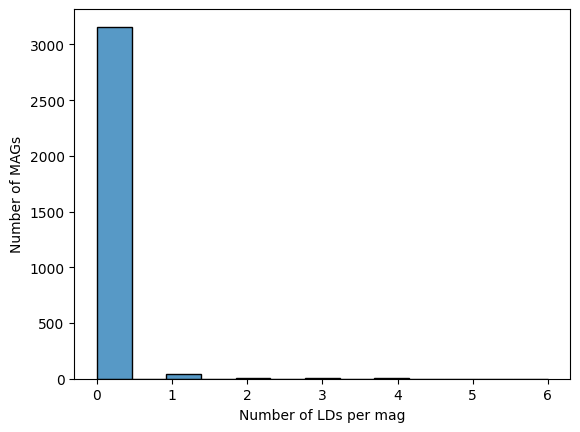

In [14]:
ld_per_mag = [len(top_ld_per_mag[x]) for x in top_ld_per_mag]
g = sns.histplot(ld_per_mag)
l = g.set_xlabel('Number of LDs per mag')
l = g.set_ylabel('Number of MAGs')

From the correlation matrix `corr_matrix` above, we already know which features (taxa + functions) correlate with each latent dimension.

We can assign each latent dimension to clusters that contain its top-correlated features:

In [15]:
ld_to_clusters = {}

for ld in corr_matrix.columns:
    # Find features most strongly correlated with this LD (top 10% absolute correlation)
    threshold = corr_matrix[ld].abs().quantile(0.90)
    top_features = corr_matrix.index[corr_matrix[ld].abs() >= threshold]
    
    # Find which clusters those features belong to
    clusters_for_ld = cluster_assignments.loc[
        cluster_assignments["Feature"].isin(top_features), "COPF"
    ].unique().tolist()
    
    ld_to_clusters[ld] = clusters_for_ld


## Combine mags and clusters

Now we get to the crux of the story - which MAGs are correalted with which clusters (and vice-versa). We need to use the latent dimensions as our intermediary, but ultimately this is where the biology gets interesting

In [16]:
mag_to_clusters = {}
clusters_to_mags = defaultdict(list)

for mag, lds in top_ld_per_mag.items():
    clusters = set()
    for ld in lds:
        clusters.update(ld_to_clusters.get(ld, []))
    mag_to_clusters[mag] = sorted(clusters)
    for c in clusters:
        clusters_to_mags[str(c)].append(mag)

## Explore some interesting clusters or MAGs

For our first test, we are curious which MAGs correlate with cluster 31 - the _Pseudomonas_ cluster. 

Note that the only MAG annotated as coming from _Pseudomonas_ is **mag_12**

In [17]:
ic = clusters_to_mags['31']
print(f"There are {len(mag_metadata[mag_metadata['MAG'].isin(ic)].index)} MAGs correlated with 31", file=sys.stderr)
mag_metadata[mag_metadata['MAG'].isin(ic)].sort_values(by='Bin Id')

There are 19 MAGs correlated with 31


,MAG,CheckM,UID,# genomes,# markers,# marker sets,0,1,2,3,4,5+,Completeness,Contamination,Strain heterogeneity,BV-BRC Mash,contigs,total size,BV-BRC Protein,GTDB
Bin Id,,,,,,,,,,,,,,,,,,,,
3,mag_3,o__Actinomycetales,(UID1809),267,400,222,2,386,12,0,0,0,99.40,1.63,50.0,Corynebacterium,48,2019611,Corynebacterium,Corynebacterium
2906,mag_2906,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,1,43429,EV_7000000144.a_SRS045715_LANL_scaffold_90836....,Unclassified
3407,mag_3407,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,25,69084,Rothia,Rothia
3848,mag_3848,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,22461,Rothia,Unclassified
5385,mag_5385,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,15,46716,Staphylococcus,NaN
19647,mag_19647,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,22111,Rothia,NaN
38045,mag_38045,o__Actinomycetales,(UID1530),622,255,150,215,40,0,0,0,0,11.67,0.00,0.0,Rothia,89,231711,Rothia,Rothia
39043,mag_39043,k__Bacteria,(UID203),5449,104,58,102,2,0,0,0,0,1.02,0.00,0.0,Unknown,13,43757,Rothia,NaN
39065,mag_39065,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,15,46275,Unclassified,NaN


### Mag_12 doesn't correlate with any clusters

In [18]:
mag_to_clusters['mag_12']

[]

### These are some other COPFs we are interested in

In [19]:
cpafs = [29, 68, 82]

In [20]:
clusters_to_mags['82']

['mag_3',
 'mag_3407',
 'mag_3848',
 'mag_5385',
 'mag_19647',
 'mag_37804',
 'mag_37811',
 'mag_37846',
 'mag_38251',
 'mag_39043',
 'mag_39065',
 'mag_39804',
 'mag_39939',
 'mag_40916',
 'mag_41134',
 'mag_41192',
 'mag_41407',
 'mag_41634',
 'mag_42392',
 'mag_42397',
 'mag_44313',
 'mag_44342',
 'mag_46940']

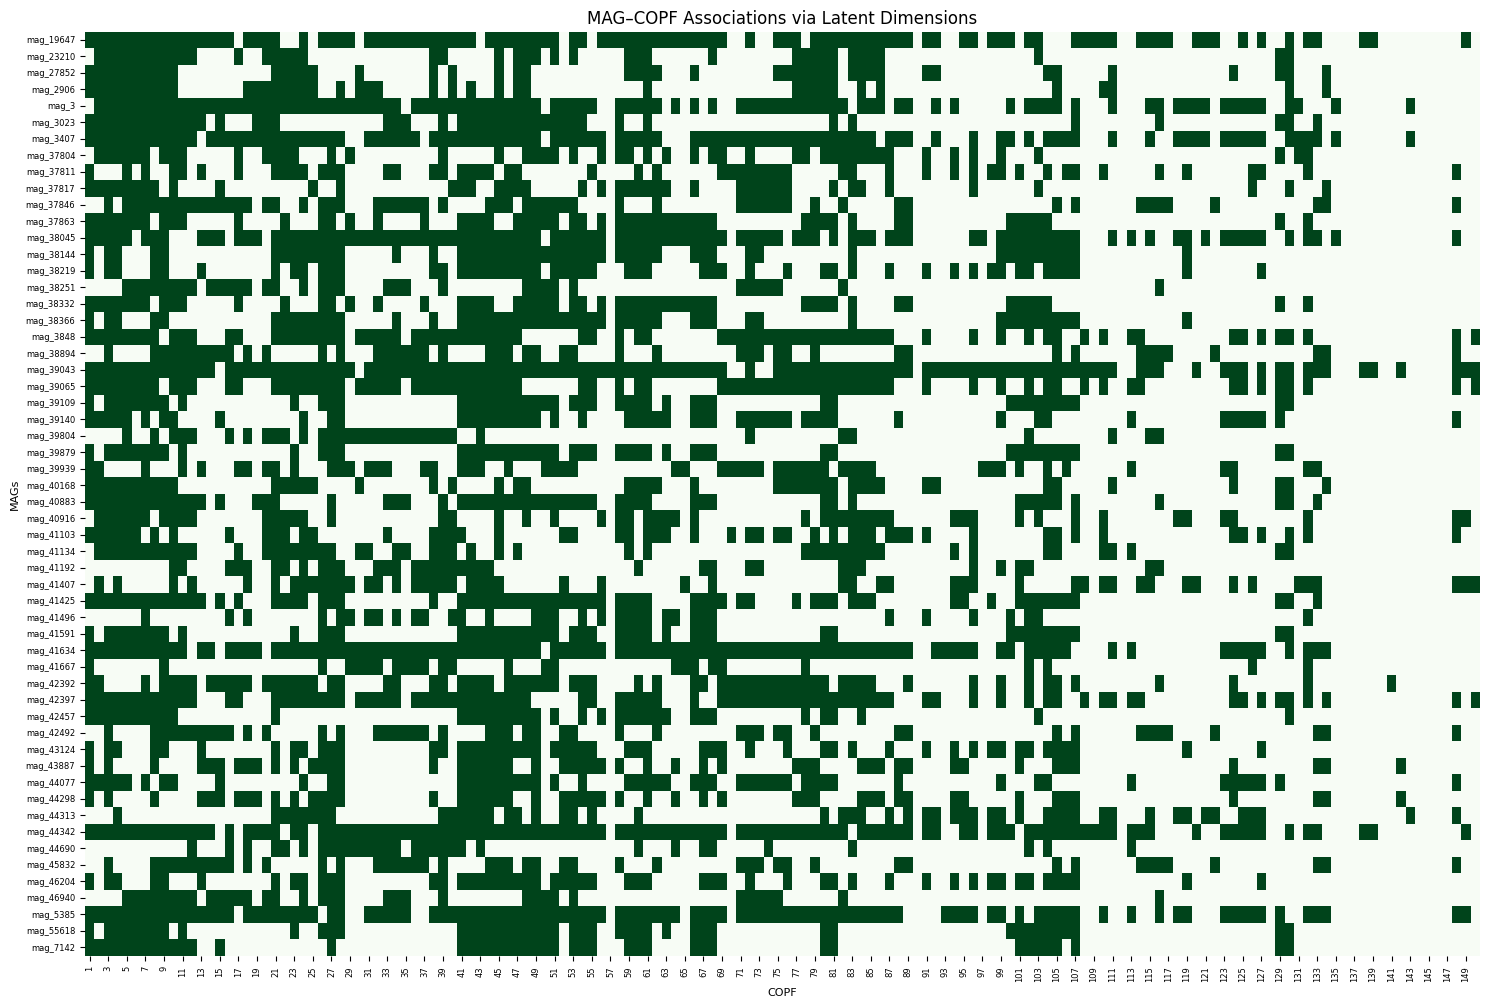

In [21]:
mag_names = sorted(mag_to_clusters.keys())
cluster_ids = sorted(cluster_assignments["COPF"].unique())
assoc = pd.DataFrame(0, index=mag_names, columns=cluster_ids)

for mag, clusts in mag_to_clusters.items():
    assoc.loc[mag, clusts] = 1

# drop empty rows
assoc = assoc[assoc.sum(axis=1) > 0]
# drop empty columns
# assoc = assoc.loc[:, assoc.sum(axis=0) > 0]

fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(assoc, cmap="Greens", cbar=False, ax=ax)

plt.xlabel("COPF")
plt.ylabel("MAGs")
ax.tick_params(axis='both', labelsize=6)
ax.yaxis.label.set_fontsize(8)
ax.xaxis.label.set_fontsize(8)
plt.title("MAG–COPF Associations via Latent Dimensions")
plt.show()

In [22]:
mag_metadata[mag_metadata['MAG'].isin(assoc.index)]

,MAG,CheckM,UID,# genomes,# markers,# marker sets,0,1,2,3,4,5+,Completeness,Contamination,Strain heterogeneity,BV-BRC Mash,contigs,total size,BV-BRC Protein,GTDB
Bin Id,,,,,,,,,,,,,,,,,,,,
3,mag_3,o__Actinomycetales,(UID1809),267,400,222,2,386,12,0,0,0,99.40,1.63,50.0,Corynebacterium,48,2019611,Corynebacterium,Corynebacterium
2906,mag_2906,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,1,43429,EV_7000000144.a_SRS045715_LANL_scaffold_90836....,Unclassified
3023,mag_3023,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,14,59814,Gardnerella,Unclassified
3407,mag_3407,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,25,69084,Rothia,Rothia
3848,mag_3848,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,22461,Rothia,Unclassified
5385,mag_5385,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,15,46716,Staphylococcus,NaN
7142,mag_7142,k__Bacteria,(UID203),5449,104,58,97,7,0,0,0,0,10.34,0.00,0.0,Prevotella,171,555679,Prevotella,Prevotella
19647,mag_19647,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,22111,Rothia,NaN
23210,mag_23210,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,13,33708,Gemella,NaN
